In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from __future__ import division
import sys
import os
sys.path.append('../')
from fastai.vision import *
from modules.basics import *
from PIL import Image, ImageDraw, ImageFont
from concurrent.futures import ProcessPoolExecutor
from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split

In [3]:
DATA_PATH = DATA_PATH/'wine'

In [4]:
IMG_PATH, DATA_PATH

(PosixPath('/home/giles/Documents/kaggle/higgsml'), PosixPath('../data/wine'))

In [5]:
IMG_PATH = DATA_PATH

In [6]:
wine = load_wine()

In [7]:
wine

{'data': array([[1.423e+01, 1.710e+00, 2.430e+00, 1.560e+01, ..., 5.640e+00, 1.040e+00, 3.920e+00, 1.065e+03],
        [1.320e+01, 1.780e+00, 2.140e+00, 1.120e+01, ..., 4.380e+00, 1.050e+00, 3.400e+00, 1.050e+03],
        [1.316e+01, 2.360e+00, 2.670e+00, 1.860e+01, ..., 5.680e+00, 1.030e+00, 3.170e+00, 1.185e+03],
        [1.437e+01, 1.950e+00, 2.500e+00, 1.680e+01, ..., 7.800e+00, 8.600e-01, 3.450e+00, 1.480e+03],
        ...,
        [1.340e+01, 3.910e+00, 2.480e+00, 2.300e+01, ..., 7.300e+00, 7.000e-01, 1.560e+00, 7.500e+02],
        [1.327e+01, 4.280e+00, 2.260e+00, 2.000e+01, ..., 1.020e+01, 5.900e-01, 1.560e+00, 8.350e+02],
        [1.317e+01, 2.590e+00, 2.370e+00, 2.000e+01, ..., 9.300e+00, 6.000e-01, 1.620e+00, 8.400e+02],
        [1.413e+01, 4.100e+00, 2.740e+00, 2.450e+01, ..., 9.200e+00, 6.100e-01, 1.600e+00, 5.600e+02]]),
 'target': array([0, 0, 0, 0, ..., 2, 2, 2, 2]),
 'target_names': array(['class_0', 'class_1', 'class_2'], dtype='<U7'),
 'DESCR': '.. _wine_dataset:\n\n

In [8]:
wine = load_wine()
df = pd.DataFrame(data=np.c_[wine['data'], wine['target']].astype('float32'),
                  columns=wine['feature_names'] + ['target'])
df.target = df.target.values.astype(int)

In [9]:
train_feats = wine['feature_names']; print(len(df));df.head()

178


,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,target
0,14.23,1.71,2.43,15.600000,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,0
1,13.20,1.78,2.14,11.200000,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,0
2,13.16,2.36,2.67,18.600000,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,0
3,14.37,1.95,2.50,16.799999,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,0
4,13.24,2.59,2.87,21.000000,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,0


In [10]:
len(train_feats)

13

In [11]:
font = ImageFont.truetype('FreeMonoBold.ttf', 13)

In [12]:
def event2img(event:np.ndarray, size:int=224) -> PIL.Image.Image:
    img = Image.fromarray(np.zeros([size,size,3]), 'RGB')
    for i, f in enumerate(event):
        ImageDraw.Draw(img).text((((1/3)+(i%2))*size//2,(size//11)+((i//2)*1.7*size//len(event))), f'{f:.1f}', fill=(255,255,255), font=font)
    return img

CPU times: user 1.82 ms, sys: 2.98 ms, total: 4.8 ms
Wall time: 3.95 ms


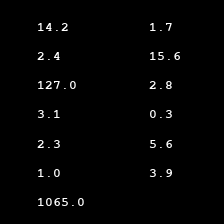

In [13]:
%%time
event2img(df[train_feats].values[0])

In [14]:
for mode in ['train']: os.makedirs(IMG_PATH/'images'/mode, exist_ok=True)

In [15]:
def save_image(event:np.ndarray, name:Union[str, int, float], loc:Path, size:int=224) -> None:
    img = event2img(event, size)
    name = str(name)
    if '.' not in name: name += '.png'
    img.save(loc/name)

In [16]:
def proc_sample(df:pd.DataFrame, mode:str, size:int=224) -> None:
    func = partial(save_image, loc=IMG_PATH/'images'/mode, size=size)
    with ProcessPoolExecutor(10) as e: e.map(func, df[train_feats].values, df.index.values)

In [17]:
%%time
proc_sample(df, 'train')

CPU times: user 95.2 ms, sys: 68.7 ms, total: 164 ms
Wall time: 246 ms


In [18]:
df.reset_index(inplace=True)
df.rename(columns={'index':'image_name'}, inplace=True)
df.to_csv(IMG_PATH/'train.csv', index=False)